Exploring Feature Selection

            Specs          Score
13            ram  931267.519053
11      px_height   17363.569536
0   battery_power   14129.866576
12       px_width    9810.586750
8       mobile_wt      95.972863
6      int_memory      89.839124
15           sc_w      16.480319
16      talk_time      13.236400
4              fc      10.135166
14           sc_h       9.614878
[0.06185917 0.02036437 0.03313032 0.01970715 0.03267692 0.01636466
 0.0358136  0.03399005 0.03645572 0.03312546 0.03344842 0.04680499
 0.0476987  0.3920659  0.03389782 0.0359459  0.03426336 0.01391066
 0.0187447  0.01973213]


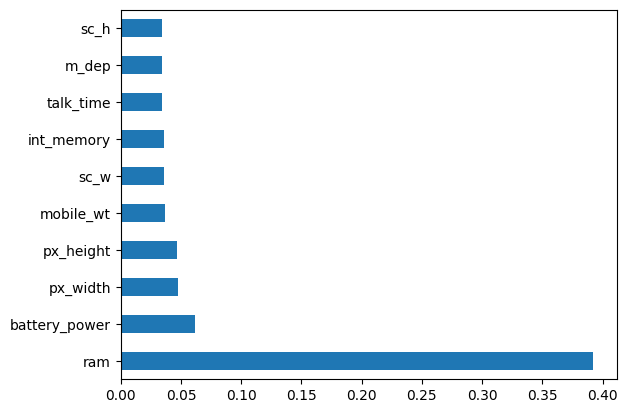

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
data = pd.read_csv("train.csv")
X = data.iloc[:,0:20] #independent columns
y = data.iloc[:,-1] #target column i.e price range
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score'] #naming the dataframe columns
print(featureScores.nlargest(10,'Score')) #print 10 best features
X = data.iloc[:,0:20] #independent columns
y = data.iloc[:,-1] #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()


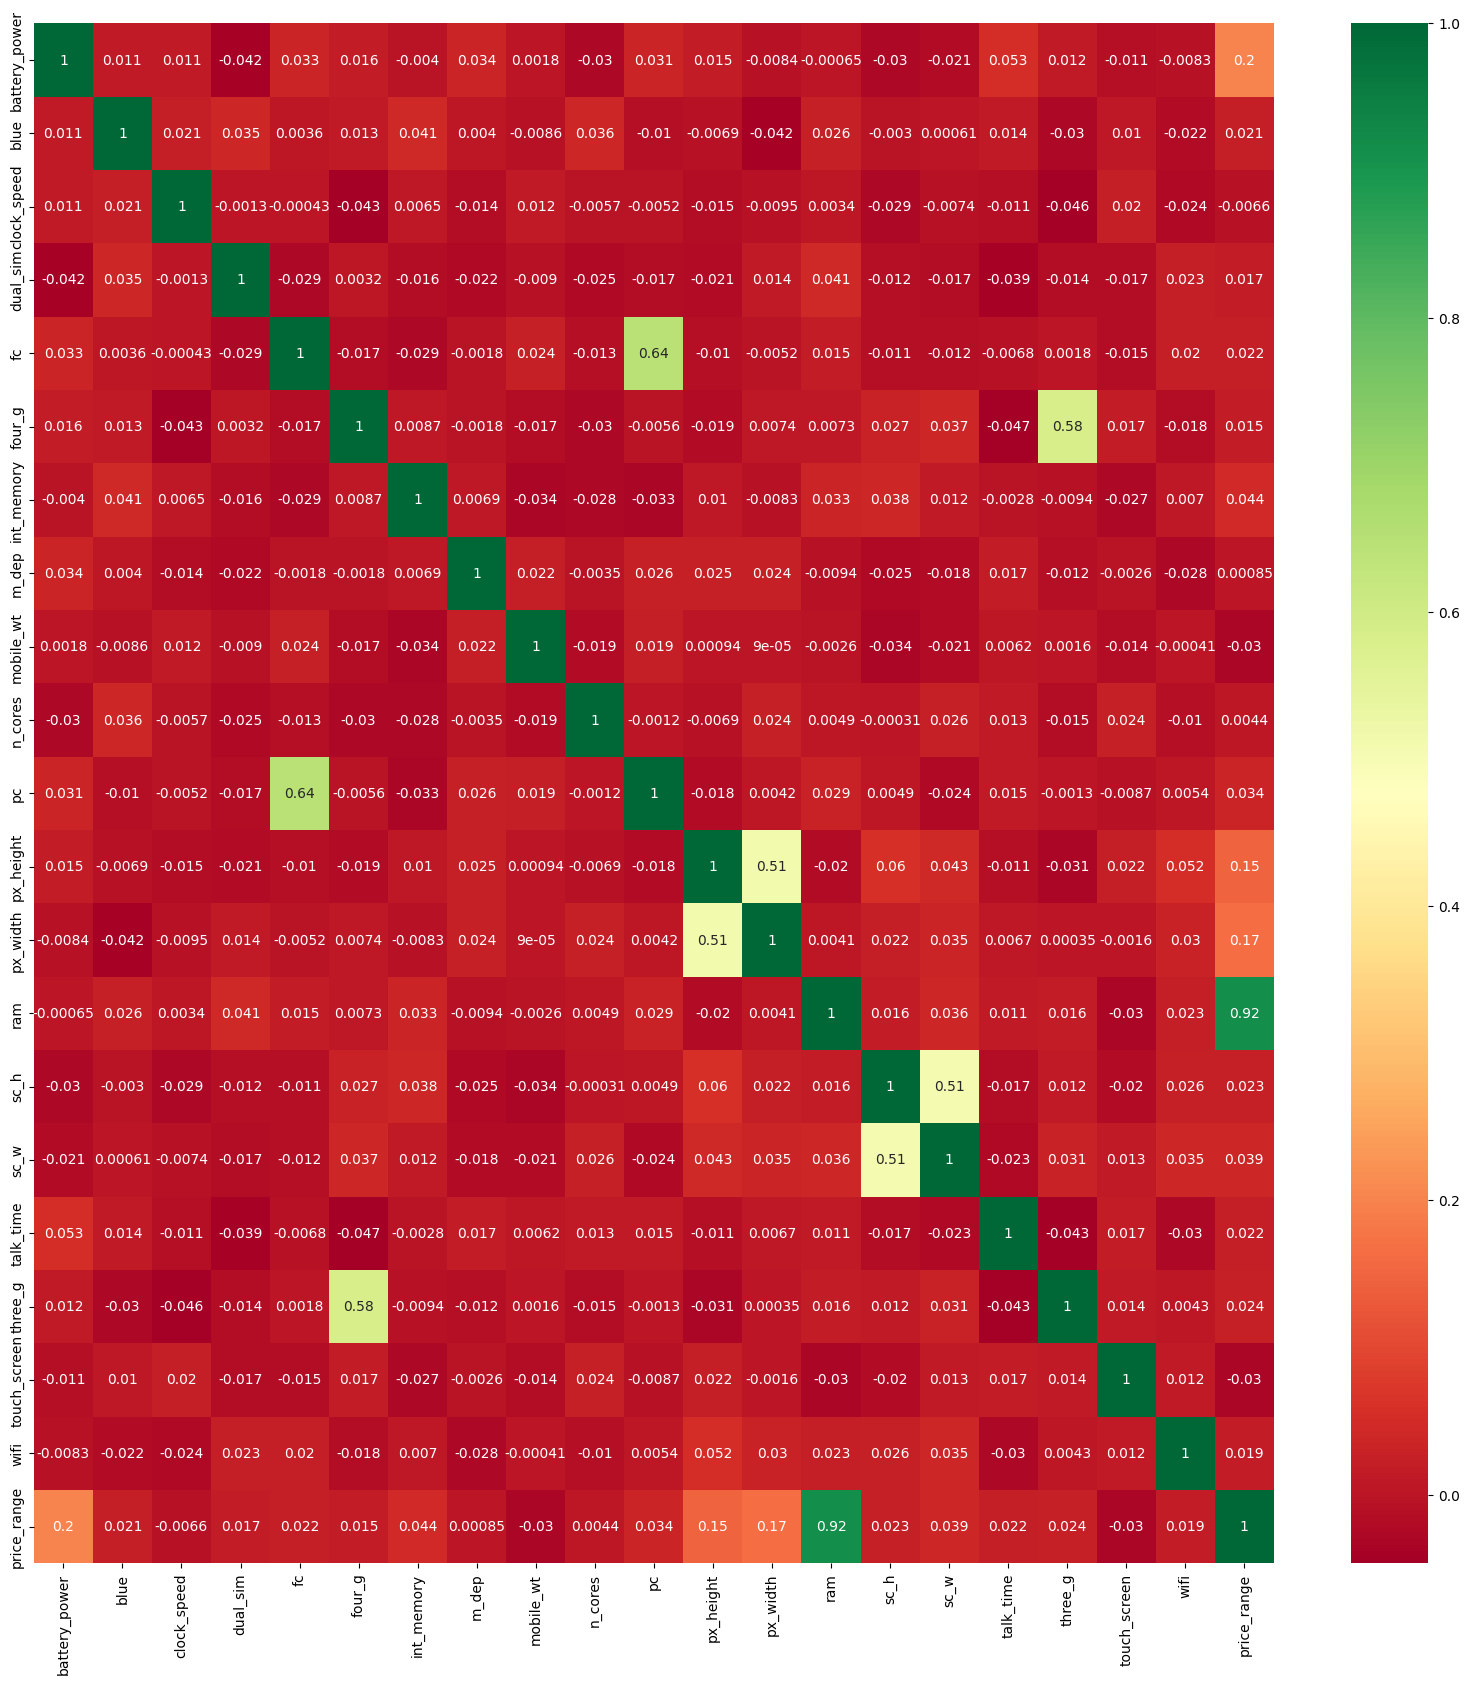

In [3]:
import seaborn as sns
X = data.iloc[:,0:20] #independent columns
y = data.iloc[:,-1] #target column i.e price range
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Classification Model Development

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Load the data
glass = pd.read_csv('glass.csv')

# Drop the ID column
glass = glass.drop('idno', axis=1)

# # Show basic info
# print(glass.info())
# print(glass.head())

# Check for missing values
print("Missing values in each column:")
print(glass.isnull().sum())
print()


# Separate features and target
X = glass.drop('type', axis=1)
y = glass['type']

# Train-test split (80/20, stratified, seed=10)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, stratify=y)

selector = SelectKBest(score_func=f_classif, k=5)
selector.fit(X_train, y_train)
top5_uni = X.columns[selector.get_support()].tolist()
print('Top 5 Univariate Features:', top5_uni)

rf = ExtraTreesClassifier(random_state=10)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=X.columns)
top5_imp = importances.sort_values(ascending=False).head(5).index.tolist()
print('Top 5 Important Features:', top5_imp)

correlations = X_train.corrwith(y_train).abs()
top5_corr = correlations.sort_values(ascending=False).head(5).index.tolist()
print('Top 5 Correlated Features:', top5_corr)
print()

def evaluate_model(X_tr, X_te, y_tr, y_te, features, label):
    gnb = GaussianNB()
    gnb.fit(X_tr[features], y_tr)
    y_pred = gnb.predict(X_te[features])
    cv = KFold(n_splits=8, shuffle=True, random_state=10)
    cv_scores = cross_val_score(gnb, X_tr[features], y_tr, cv=cv, scoring='accuracy')
    # report = classification_report(y_te, y_pred, output_dict=True)
    print(f'--- {label} ---')
    print('Test Accuracy:', accuracy_score(y_te, y_pred))
    print('Test Precision:', precision_score(y_te, y_pred, average="weighted", zero_division=0))
    print('Test Recall:', recall_score(y_te, y_pred, average="weighted", zero_division=0))
    print('Test F1:', f1_score(y_te, y_pred, average="weighted", zero_division=0))
    print('CV Mean Accuracy:', np.mean(cv_scores))
    print('Classification Report:\n', classification_report(y_te, y_pred))

evaluate_model(X_train, X_test, y_train, y_test, X.columns, 'All Features')
evaluate_model(X_train, X_test, y_train, y_test, top5_uni, 'Univariate Selection')
evaluate_model(X_train, X_test, y_train, y_test, top5_imp, 'Feature Importance')
evaluate_model(X_train, X_test, y_train, y_test, top5_corr, 'Correlation')
